In [13]:
from __future__ import annotations

import relaxed
import jax
import jax.numpy as jnp
from jax.random import PRNGKey, multivariate_normal
import pyhf
from typing import Callable, Any
from functools import partial

jax.config.update("jax_enable_x64", True)
pyhf.set_backend("jax")

# matplotlib settings
plt.rc("figure", figsize=(6, 3), dpi=150, facecolor="w")
plt.rc("legend", fontsize=6)

Array = jnp.ndarray

# specific also
def generate_data(
    rng=0,
    num_points=10000,
    sig_mean=(-1, 1),
    bup_mean=(4.5, 2),
    bdown_mean=(-2.5, -2.5),
    b_mean=(0, 0),
):
    sig = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(sig_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    bkg_up = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(bup_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    bkg_down = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(bdown_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )

    bkg_nom = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(b_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    return sig, bkg_nom, bkg_up, bkg_down


def hists_from_pars(
    pars: dict[str, Array],
    data: dict[str, Array],
    nn: Callable,
    bandwidth: float,
    bins: Array | None = None,
    scale_factors: dict[str, float] | None = None,
    overall_scale: float = 10.0,
) -> dict[str, Array]:
    """Function that takes in data + analysis config parameters, and constructs yields."""
    nn_output = {k: nn(pars["nn_pars"], data[k]).ravel() for k in data}
    bins = pars["bins"] if "bins" in pars else bins
    # make sure bins don't overlap
    bins_new = jnp.concatenate(
        (
            jnp.array([bins[0]]),
            jnp.where(bins[1:] > bins[:-1], bins[1:], bins[:-1] + 1e-4),
        ),
        axis=0,
    )
    make_hist = partial(relaxed.hist, bandwidth=bandwidth, bins=bins_new)
    scale_factors = scale_factors or {k: 1.0 for k in nn_output}
    # every histogram is scaled to the number of points from that data source in the batch
    # so we have more control over the scaling of sig/bkg for realism
    hists = {
        k: make_hist(nn_output[k]) * scale_factors[k] * overall_scale / len(v)
        + 1e-3  # no zeros!
        for k, v in nn_output.items()
    }
    return hists


# specific to use case
def model_from_hists(hists: dict[str, Array]) -> pyhf.Model:
    """How to make your HistFactory model from your histograms."""
    spec = {
        "channels": [
            {
                "name": "singlechannel",
                "samples": [
                    {
                        "name": "signal",
                        "data": hists["sig"],
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data": None},
                        ],
                    },
                    {
                        "name": "background",
                        "data": hists["bkg_nominal"],
                        "modifiers": [
                            {
                                "name": "correlated_bkg_uncertainty",
                                "type": "histosys",
                                "data": {
                                    "hi_data": hists["bkg_up"],
                                    "lo_data": hists["bkg_down"],
                                },
                            },
                        ],
                    },
                ],
            },
        ],
    }
    return pyhf.Model(spec, validate=False)


def poi_uncert(model: pyhf.Model) -> float:
    hypothesis_pars = (
        jnp.asarray(model.config.suggested_init()).at[model.config.poi_index].set(1.0)
    )
    observed_hist = jnp.asarray(model.expected_data(hypothesis_pars))
    return relaxed.cramer_rao_uncert(model, hypothesis_pars, observed_hist)[
        model.config.poi_index
    ]


def discovery_significance(model: pyhf.Model, fit_lr: float) -> float:
    test_stat = "q0"
    test_poi = 0.0
    hypothesis_pars = (
        jnp.asarray(model.config.suggested_init()).at[model.config.poi_index].set(1.0)
    )
    observed_hist = jnp.asarray(model.expected_data(hypothesis_pars))
    return relaxed.infer.hypotest(
        test_poi=test_poi,
        data=observed_hist,
        model=model,
        test_stat=test_stat,
        expected_pars=hypothesis_pars,
        lr=fit_lr,
    )


def cls_value(model: pyhf.Model, fit_lr: float) -> float:
    test_stat = "q"
    test_poi = 1.0
    hypothesis_pars = (
        jnp.asarray(model.config.suggested_init()).at[model.config.poi_index].set(0.0)
    )
    observed_hist = jnp.asarray(model.expected_data(hypothesis_pars))
    return relaxed.infer.hypotest(
        test_poi=test_poi,
        data=observed_hist,
        model=model,
        test_stat=test_stat,
        expected_pars=hypothesis_pars,
        lr=fit_lr,
    )


def generalised_variance(model: pyhf.Model) -> float:
    hypothesis_pars = (
        jnp.asarray(model.config.suggested_init()).at[model.config.poi_index].set(0.0)
    )
    observed_hist = jnp.asarray(model.expected_data(hypothesis_pars))
    return jnp.linalg.det(
        jnp.linalg.inv(relaxed.fisher_info(model, hypothesis_pars, observed_hist))
    )


def loss_from_model(
    model: pyhf.Model,
    loss: str | Callable[[dict[str, Any]], float] = "neos",
    fit_lr: float = 1e-3,
) -> float:
    if isinstance(loss, Callable):
        # everything
        return 0
    # loss specific
    if loss.lower() == "discovery":
        return discovery_significance(model, fit_lr)
    elif loss.lower() in ["neos", "cls"]:
        return cls_value(model, fit_lr)
    elif loss.lower() in ["inferno", "poi_uncert", "mu_uncert"]:
        return poi_uncert(model)
    elif loss.lower() in [
        "general_variance",
        "generalised_variance",
        "generalized_variance",
    ]:
        return generalised_variance(model)
    else:
        raise ValueError(f"loss function {loss} not recognised")


def pipeline(pars, data, bins, nn, loss, bandwidth, keys, scale_factors):
    hists = hists_from_pars(
        pars=pars,
        nn=nn,
        data={k: v for k, v in zip(keys, data)},
        bandwidth=bandwidth,
        bins=bins,
        scale_factors=scale_factors,
    )
    model = model_from_hists(hists)
    return loss_from_model(model, loss=loss)

In [2]:
from jax.experimental import stax

rng_state = 0  # random state

# feel free to modify :)
init_random_params, nn = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid,
)

num_features = 2
_, init = init_random_params(PRNGKey(rng_state), (-1, num_features))
init_pars = dict(nn_pars=init)

/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [3]:
from sklearn.model_selection import train_test_split
import numpy.random as npr

batch_size = 256

data = generate_data(rng=rng_state, num_points=10000)
split = train_test_split(*data, random_state=rng_state)
train, test = split[::2], split[1::2]

num_train = train[0].shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

# batching mechanism
def data_stream():
    rng = npr.RandomState(rng_state)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size : (i + 1) * batch_size]
            yield [points[batch_idx] for points in train]


batch_iterator = data_stream()

In [18]:
from jaxopt import OptaxSolver
import optax
from time import perf_counter

include_bins = True
bins = jnp.linspace(0, 1, 5)
lr = 6e-3
num_steps = 100
data_types = ["sig", "bkg_nominal", "bkg_up", "bkg_down"]
loss = partial(
    pipeline,
    nn=nn,
    keys=data_types,
    scale_factors={k: 2.0 if k == "sig" else 10.0 for k in data_types},
)

solver = OptaxSolver(loss, opt=optax.adam(lr), jit=True)

pyhf.set_backend("jax", default=True)
if include_bins:
    init_pars["bins"] = bins
    state = solver.init_state(init_pars)
else:
    if "bins" in init_pars:
        del init_pars["bins"]
    state = solver.init_state(init_pars)
params = init_pars
metrics = {k: [] for k in ["cls", "discovery", "generalised_variance"]}
objective = "cls"
for i in range(num_steps):
    print(f"step {i}: loss={objective}")
    data = next(batch_iterator)
    start = perf_counter()
    params, state = solver.update(
        params, state, bins=bins, data=data, loss=objective, bandwidth=1e-1
    )
    end = perf_counter()
    print(f"update took {end-start:.4g}s")
    if "bins" in params:
        print("bin edges: [", *[f"{f:.3g}" for f in params["bins"]], "]")
    for metric in metrics:
        test_metric = loss(params, bins=bins, data=test, loss=metric, bandwidth=1e-8)
        print(f"{metric}={test_metric:.4g}")
        metrics[metric].append(test_metric)
    print()

step 0: loss=cls
update took 2.094s
cls=0.1298
discovery=0.04857
generalised_variance=163.7

step 1: loss=cls
update took 2.112s
cls=0.03993
discovery=0.01777
generalised_variance=216.4

step 2: loss=cls
update took 2.058s
cls=0.08168
discovery=0.02933
generalised_variance=4.698

step 3: loss=cls
update took 2.107s
cls=0.04765
discovery=0.02378
generalised_variance=4.92

step 4: loss=cls
update took 2.188s
cls=0.03313
discovery=0.01691
generalised_variance=14.02

step 5: loss=cls
update took 2.096s
cls=0.02639
discovery=0.02356
generalised_variance=105.9

step 6: loss=cls
update took 2.148s
cls=0.01629
discovery=0.02559
generalised_variance=101

step 7: loss=cls
update took 2.132s
cls=0.02506
discovery=0.01038
generalised_variance=381.2

step 8: loss=cls
update took 2.061s
cls=0.02502
discovery=0.01876
generalised_variance=315.3

step 9: loss=cls
update took 2.125s
cls=0.02204
discovery=0.01612
generalised_variance=375

step 10: loss=cls
update took 2.042s
cls=0.01221
discovery=0.00411

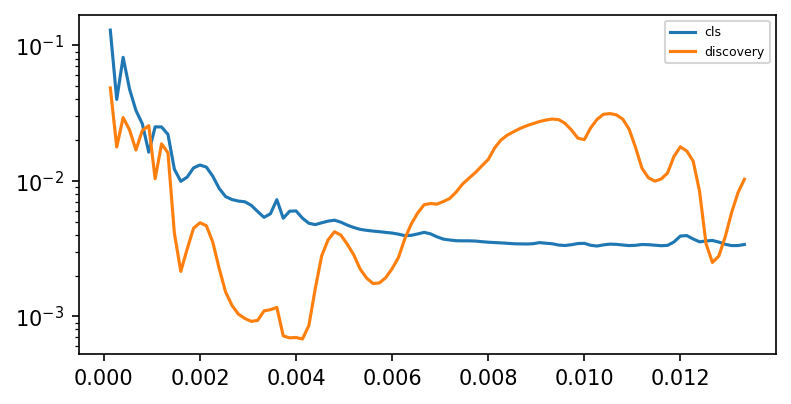

In [19]:
import matplotlib.pyplot as plt

epoch_grid = (jnp.array(list(range(1, num_steps + 1))) + batch_size) / num_train
for k, v in metrics.items():
    if k != "generalised_variance":
        plt.plot(epoch_grid, v, label=k)
plt.yscale("log")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("metric")
plt.savefig("float.png")